<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/Hawaii_Soils_Process_and_Intersect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")
install.packages("terra")
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the

In [2]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(terra)
library(randomForest)
library(parallel)

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: sp

terra 1.7.55


Attaching package: ‘terra’


The following object is masked from ‘package:data.table’:

    shift


The following objects are masked from ‘package:magrittr’:

    extract, inset


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [3]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=0ab7ca4a39044a86560c2f9c55649559&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYa1R4SXpnTFRhYm1ub0RGdHlUcVVqYUQyMGktQlJiMl9VQkdkM09MY1A2RGJwdHliWGUwb0VxNGp4RnZvMEZiZyIsInN0YXRlIjoiMGFiN2NhNGEzOTA0NGE4NjU2MGMyZjljNTU2NDk1NTkifQ==


In [4]:
dir.create('/content/predictor_variables/')

In [5]:
# Hawaii GEDI data
# https://drive.google.com/file/d/1UY3lxML0Y7bat_9-xEZQQHDkYRcODDZy/view?usp=drive_link
drive_download(file = as_id('1UY3lxML0Y7bat_9-xEZQQHDkYRcODDZy'), path =  '/content/predictor_variables/Hawaii_GEDI_4A.gpkg', overwrite = FALSE)
gedi_sf <- st_read('/content/predictor_variables/Hawaii_GEDI_4A.gpkg')

File downloaded:

• Hawaii_GEDI.gpkg <id: 1UY3lxML0Y7bat_9-xEZQQHDkYRcODDZy>

Saved locally as:

• /content/predictor_variables/Hawaii_GEDI_4A.gpkg



Reading layer `Hawaii_GEDI_2' from data source 
  `/content/predictor_variables/Hawaii_GEDI_4A.gpkg' using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 4839466 features and 28 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -160.6006 ymin: 18.86556 xmax: -154.7559 ymax: 22.28996
Geodetic CRS:  WGS 84


In [6]:
# Hawaii 250m grid
# https://drive.google.com/file/d/1Jowm2XIdJHrt6N3tGhbLZ81UZZVMqAW8/view?usp=drive_link
drive_download(file = as_id('1Jowm2XIdJHrt6N3tGhbLZ81UZZVMqAW8'), path =  '/content/predictor_variables/HI_island_250_m_grid.gpkg', overwrite = FALSE)

File downloaded:

• HI_island_250_m_grid.gpkg <id: 1Jowm2XIdJHrt6N3tGhbLZ81UZZVMqAW8>

Saved locally as:

• /content/predictor_variables/HI_island_250_m_grid.gpkg



In [7]:
folder_loc <- '/content/predictor_variables/TerraClimate/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1bIbwKYmzP2o6VEAWyLIRmeMQbGFDt-vX?usp=drive_link
folder_id <- "1bIbwKYmzP2o6VEAWyLIRmeMQbGFDt-vX"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}


File downloaded:

• Maui_Mean_Climate_1958_to_2023.tif <id: 1Aglg9-srq187HYR38PFBVrodg3PpcqbE>

Saved locally as:

• /content/predictor_variables/TerraClimate/Maui_Mean_Climate_1958_to_2023.tif

File downloaded:

• Lanai_Mean_Climate_1958_to_2023.tif <id: 1eFkEW2ZRWtMK-IMEpVJ28R3xups_HhOT>

Saved locally as:

• /content/predictor_variables/TerraClimate/Lanai_Mean_Climate_1958_to_2023.tif

File downloaded:

• Molokai_Mean_Climate_1958_to_2023.tif <id: 18SNFZ6VefxYbEEtWl1nXDj8JJFLdFDo_>

Saved locally as:

• /content/predictor_variables/TerraClimate/Molokai_Mean_Climate_1958_to_2023.tif

File downloaded:

• Hawaii_Mean_Climate_1958_to_2023.tif <id: 1pMs5OsTwQ1N3kXO9bb3W-qfhxwcJtzIj>

Saved locally as:

• /content/predictor_variables/TerraClimate/Hawaii_Mean_Climate_1958_to_2023.tif

File downloaded:

• Kauai_Mean_Climate_1958_to_2023.tif <id: 14bpiZID-VOQmsEVeQc9gFHe8JYK7w_ew>

Saved locally as:

• /content/predictor_variables/TerraClimate/Kauai_Mean_Climate_1958_to_2023.tif

File downlo

In [8]:
folder_loc <- '/content/predictor_variables/SRTM_mTPI/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1YKJrZXTo-L4UpvJ0iEGo8yIX6uhoQ9AW?usp=drive_link
folder_id <- "1YKJrZXTo-L4UpvJ0iEGo8yIX6uhoQ9AW"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Metadata <id: 1GB4d-4-xOOFHbf6R8z8yw5ZVYe4n-Oz-lSM43dpESb0>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Metadata.docx

File downloaded:

• Molakai_SRTM_mTPI_Buffer.tif <id: 1WRDZse9NGahMQ4h22bxvsv4XFp10JJZW>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Molakai_SRTM_mTPI_Buffer.tif

File downloaded:

• Oahu_SRTM_mTPI_Buffer.tif <id: 1MJEjAuHBeDmvfU_7W4j6RZJk6uLD4TE_>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Oahu_SRTM_mTPI_Buffer.tif

File downloaded:

• Kauai_SRTM_mTPI_Buffer.tif <id: 1APv2WFDHdAiwOhBcAw8db-b1NSIlsK1K>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Kauai_SRTM_mTPI_Buffer.tif

File downloaded:

• Lanai_SRTM_mTPI_Buffer.tif <id: 1sz3x9fZufpjbtrIpY3ZovhNknmDmkR5n>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Lanai_SRTM_mTPI_Buffer.tif

File downloaded:

• Niihau_SRTM_mTPI_Buffer.tif <id: 1JlGaWub7TJ31v7V1GSDQRIq5Mw4wcZx0>

Saved locally as:

• /content/predictor_variables

In [9]:
folder_loc <- '/content/predictor_variables/Elevation/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1XmH9T9xVINZZfPFi39Wus1l7c0SKS4Am?usp=drive_link
folder_id <- "1XmH9T9xVINZZfPFi39Wus1l7c0SKS4Am"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Kauai_elevation.tif <id: 1SNmoJcKsyKSlG5DVye0c1pHvgWEQ5f1r>

Saved locally as:

• /content/predictor_variables/Elevation/Kauai_elevation.tif

File downloaded:

• Oahu_elevation-0000000000-0000046592.tif
  <id: 1yRDrfvLTEGECTDQcwXRIxoHmUu3D9LL4>

Saved locally as:

• /content/predictor_variables/Elevation/Oahu_elevation-0000000000-0000046592.tif

File downloaded:

• Maui_elevation.tif <id: 1Or-pj4QiOj8VgMOAPtVjMm_ocbrvGM6_>

Saved locally as:

• /content/predictor_variables/Elevation/Maui_elevation.tif

File downloaded:

• Molokai_elevation.tif <id: 1ae2lpPQngdFx58mRpqt02Z1bQg-Tifen>

Saved locally as:

• /content/predictor_variables/Elevation/Molokai_elevation.tif

File downloaded:

• Niihau_elevation.tif <id: 1L6lodPtr7u70scb-gu_QliaAIyEwYAtc>

Saved locally as:

• /content/predictor_variables/Elevation/Niihau_elevation.tif

File downloaded:

• Oahu_elevation-0000000000-0000000000.tif
  <id: 1YMV_pXPQjmdam7ucBItWqzFJPPYQK7H5>

Saved locally as:

• /content/predicto

In [10]:
folder_loc <- '/content/predictor_variables/LandForms/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1PkUR4GK50wC6Kgrvyy-d6067ypdX1dkx?usp=drive_link
folder_id <- "1PkUR4GK50wC6Kgrvyy-d6067ypdX1dkx"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Landforms_Buffer_2000m.tif <id: 1HMIkKM_02cVNWaB7-IYwnd414Wg5acnK>

Saved locally as:

• /content/predictor_variables/LandForms/Landforms_Buffer_2000m.tif

File downloaded:

• Kauai_Landforms_Buffer.tif <id: 1oRmeE1kg5GswFcDdUaGU5jnui9Y2DpR3>

Saved locally as:

• /content/predictor_variables/LandForms/Kauai_Landforms_Buffer.tif

File downloaded:

• Oahu_Landforms_Buffer-0000000000-0000065536.tif
  <id: 1PcZoQe0l8WLgSagiWWUpTmWmmHmGnIRx>

Saved locally as:

• /content/predictor_variables/LandForms/Oahu_Landforms_Buffer-0000000000-0000065536.tif

File downloaded:

• Molakai_Landforms_Buffer.tif <id: 1ZBdccF_ELdIApV0SkAv2ZfWsZ0a0ae1f>

Saved locally as:

• /content/predictor_variables/LandForms/Molakai_Landforms_Buffer.tif

File downloaded:

• Niihau_Landforms_Buffer.tif <id: 16jkuVWQ_BIjLBJiTeZeHMj3Z_FCJ4ttm>

Saved locally as:

• /content/predictor_variables/LandForms/Niihau_Landforms_Buffer.tif

File downloaded:

• Hawaii_Landforms_Buffer.tif <id: 1qBNjiXKd-JJ8CICZ

In [11]:
folder_loc <- '/content/predictor_variables/LandSat_composite/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1NzvurSghdEJdX0UsfdyuOcOyh6n3jUDo?usp=drive_link
folder_id <- "1NzvurSghdEJdX0UsfdyuOcOyh6n3jUDo"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Niihau_LS_composite_2012_2018.tif <id: 1yphCVOxcRgBOKdhvOOQunCnObkHhPWWx>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Niihau_LS_composite_2012_2018.tif

File downloaded:

• Oahu_LS_composite_2012_2018-0000000000-0000035840.tif
  <id: 1Tyc-6B7SqE1nMRBDbSzNP9KvoItaogpC>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Oahu_LS_composite_2012_2018-0000000000-0000035840.tif

File downloaded:

• Oahu_LS_composite_2012_2018-0000008960-0000026880.tif
  <id: 1yaE46GTtCsjXAhqK43HzMHgfMicRjMnK>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Oahu_LS_composite_2012_2018-0000008960-0000026880.tif

File downloaded:

• Oahu_LS_composite_2012_2018-0000008960-0000035840.tif
  <id: 1sxPsCuwNjHyfO2Sxit0jVfG_jai9IJWR>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Oahu_LS_composite_2012_2018-0000008960-0000035840.tif

File downloaded:

• Oahu_LS_composite_2012_2018-0000008960-0000071680.tif
  <id: 1

In [12]:
folder_loc <- '/content/predictor_variables/DynamicWorld_landcover/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/152pjTArpwlDVGjXFoSU9bmo1BDSKdCqq?usp=drive_link
folder_id <- "152pjTArpwlDVGjXFoSU9bmo1BDSKdCqq"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000000000-0000200448.tif
  <id: 1d1budUOMeLAnuM2sc0XRwNaGJDVYD6mi>

Saved locally as:

• /content/predictor_variables/DynamicWorld_landcover/Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000000000-0000200448.tif

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000007424-0000096512.tif
  <id: 12WZZsotfizLogT8LNfk5xnd8B_SwxmX7>

Saved locally as:

• /content/predictor_variables/DynamicWorld_landcover/Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000007424-0000096512.tif

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000007424-0000193024.tif
  <id: 1LYpsLuD3I41nw7dzn2iragALgzqlSDfe>

Saved locally as:

• /content/predictor_variables/DynamicWorld_landcover/Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000007424-0000193024.tif

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000014848-0000200448.tif
  <id: 1FaGqlWwDEWImhMgu8PRwC_YBoKOGk

In [13]:
  # https://drive.google.com/file/d/1ryTzWz0t9mgI5ynPvMzM21D135dLJvWv/view?usp=drive_link
  # Updated: https://drive.google.com/file/d/17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C/view?usp=sharing
drive_download(as_id('17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C'), path = paste0('/content/fia.csv'), overwrite = TRUE)
fia_dt <-  st_read('/content/fia.csv') %>% st_as_sf(coords = c("LON","LAT"), crs = 4326) %>% data.table

File downloaded:

• 2023_11_01FIA_soil_subset.csv <id: 17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C>

Saved locally as:

• /content/fia.csv



Reading layer `fia' from data source `/content/fia.csv' using driver `CSV'


Warning message:
“no simple feature geometries present: returning a data.frame or tbl_df”


In [14]:
fia_dt[,Stock_SOC_Mg_Ha :=  Stock_SOC_Mg_Ha %>% as.numeric,]

Warning message in Stock_SOC_Mg_Ha %>% as.numeric:
“NAs introduced by coercion”


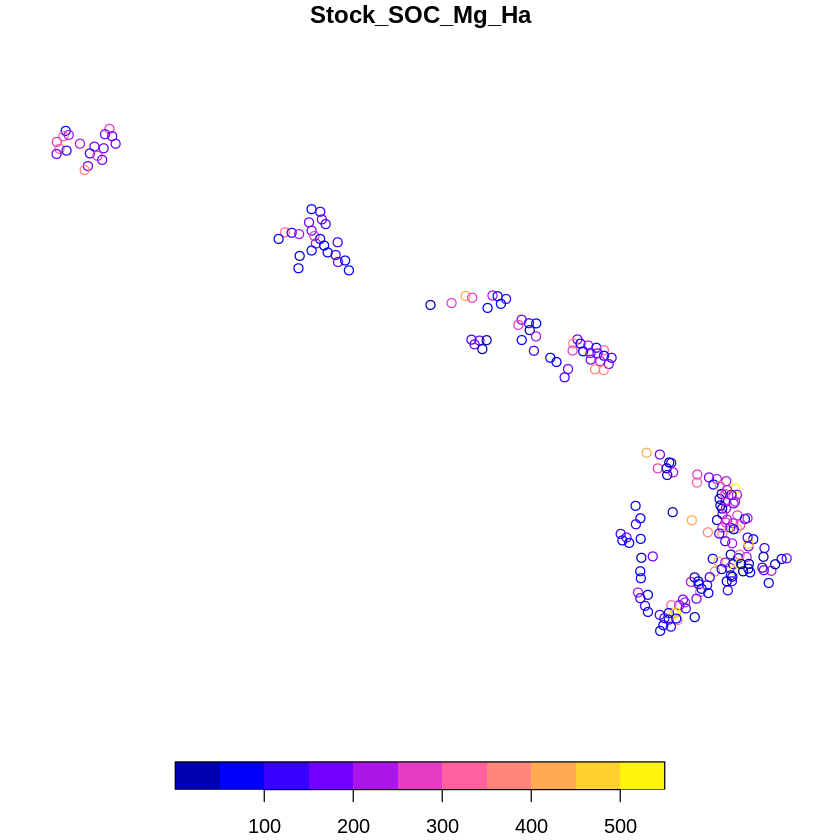

In [15]:
(fia_dt %>% st_as_sf)[,'Stock_SOC_Mg_Ha' ] %>% plot

In [16]:
dir_list <- list.dirs('/content/predictor_variables')[-1]

names(dir_list) <- list.dirs('/content/predictor_variables',full.names = FALSE)[-1]

In [17]:
names(dir_list) %>% lapply(function(x){
  print(x)
 y <- dir_list[[x]]
 vrt(y %>% lapply(function(x){
  file_list <- list.files(y, pattern='*.tif',full.names = T)
  file_sizes <- lapply(file_list,file.size) %>% unlist %>% order
  file_list[file_sizes] %>% return
  }) %>% unlist,filename=paste0(y,'/',x,'.vrt'),overwrite=T)
 print(paste('Done',x))
})

[1] "DynamicWorld_landcover"
[1] "Done DynamicWorld_landcover"
[1] "Elevation"
[1] "Done Elevation"
[1] "LandForms"
[1] "Done LandForms"
[1] "LandSat_composite"
[1] "Done LandSat_composite"
[1] "SRTM_mTPI"
[1] "Done SRTM_mTPI"
[1] "TerraClimate"
[1] "Done TerraClimate"


[[1]]
[1] "Done DynamicWorld_landcover"

[[2]]
[1] "Done Elevation"

[[3]]
[1] "Done LandForms"

[[4]]
[1] "Done LandSat_composite"

[[5]]
[1] "Done SRTM_mTPI"

[[6]]
[1] "Done TerraClimate"

In [18]:
 raster_list <- list.files('/content/predictor_variables',pattern = '*.vrt',full.names = T,recursive = T) %>% lapply(stack) %>% lapply(rast)

raster_list
  # # Use gdalbuildvrt to create VRT
  # gdalbuildvrt(destfile = paste0(x,'/',x,'.vrt'),
  #              files =   (x %>% lapply(function(x){list.files(x, pattern='*.tif',full.names = T)})),
  #              separate = FALSE, # Change to TRUE if you want separate bands
  #              overwrite = TRUE)




[[1]]
class       : SpatRaster 
dimensions  : 371833, 2204931, 10  (nrow, ncol, nlyr)
resolution  : 9.031842e-05, 9.031842e-05  (x, y)
extent      : -178.4436, 20.70229, 18.8654, 52.44877  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
source      : DynamicWorld_landcover.vrt 
names       : Dynam~ver_1, Dynam~ver_2, Dynam~ver_3, Dynam~ver_4, Dynam~ver_5, Dynam~ver_6, ... 

[[2]]
class       : SpatRaster 
dimensions  : 35816, 87898, 1  (nrow, ncol, nlyr)
resolution  : 0.0002694946, 0.0002694946  (x, y)
extent      : -178.4436, -154.7556, 18.8652, 28.51742  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
source      : Elevation.vrt 
name        : Elevation 

[[3]]
class       : SpatRaster 
dimensions  : 80530, 270460, 1  (nrow, ncol, nlyr)
resolution  : 0.0002694946, 0.0002694946  (x, y)
extent      : -178.4437, -105.5562, 18.86543, 40.56783  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
source      : 

In [19]:
gedi_dt <- st_read('/content/predictor_variables/Hawaii_GEDI_4A.gpkg') %>% data.table()

Reading layer `Hawaii_GEDI_2' from data source 
  `/content/predictor_variables/Hawaii_GEDI_4A.gpkg' using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 4839466 features and 28 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -160.6006 ymin: 18.86556 xmax: -154.7559 ymax: 22.28996
Geodetic CRS:  WGS 84


In [20]:
grid_dt <- st_read('/content/predictor_variables/HI_island_250_m_grid.gpkg') %>% data.table()

Reading layer `grid' from data source 
  `/content/predictor_variables/HI_island_250_m_grid.gpkg' using driver `GPKG'
Simple feature collection with 263630 features and 5 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 57161.36 ymin: 8702.317 xmax: 572661.4 ymax: 381202.3
Projected CRS: NAD_1983_HARN_StatePlane_Hawaii_1_FIPS_5101


Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


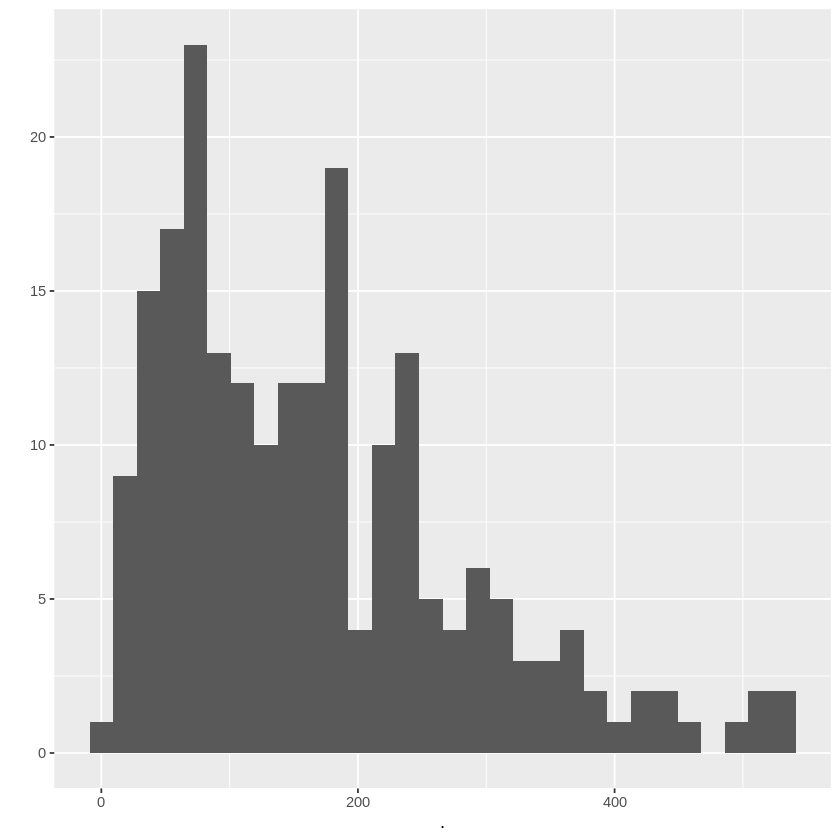

In [21]:
fia_dt[,c('Stock_SOC_Mg_Ha','geometry')]$Stock_SOC_Mg_Ha %>% qplot

In [22]:
grid_int_dt <- fia_dt[,c('PLOT','Stock_SOC_Mg_Ha','geometry')] %>% st_as_sf() %>% st_transform(4135) %>% st_buffer(10000) %>% st_transform(4326) %>% st_intersects(grid_dt %>% st_as_sf %>% st_transform(4326))

ERROR: ignored

In [24]:
grid_int_unique <- grid_int_dt %>% unlist %>% unique

In [25]:
example_poly <- grid_dt[grid_int_unique,] %>% st_as_sf %>% st_buffer(250)

In [46]:
# gedi_int_dt

In [28]:
grid_dt[grid_int_unique] %>% st_as_sf %>% st_write('grid_dt.gpkg',delete_dsn = T)

Deleting source `grid_dt.gpkg' failed
Writing layer `grid_dt' to data source `grid_dt.gpkg' using driver `GPKG'
Writing 227561 features with 5 fields and geometry type Point.


In [29]:
  example_poly <- grid_dt[grid_int_unique %>% unlist %>% unique,] %>% st_as_sf %>% st_transform(4135) %>% st_buffer(250) %>% st_transform(4326)

In [30]:
  # example_poly <- (fia_extended_dt %>%data.table)[,c('PLOT','Stock_SOC_Mg_Ha','dummy_geom')]

  cover_dt <- data.table(exact_extract(raster_list[[1]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(cover_dt) <- c("water", "trees", "grass", "flooded_vegetation", "crops", "shrub_and_scrub", "built", "bare", "snow_and_ice",'max')

  elevation_dt <- data.table(exact_extract(raster_list[[2]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(elevation_dt) <- c("elevation")

  landform_dt <- data.table(exact_extract(raster_list[[3]],example_poly %>% st_as_sf,'mode',progress = TRUE) %>% data.table)
  names(landform_dt) <- c("landform")

  ls_dt <- data.table(exact_extract(raster_list[[4]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(ls_dt) <- c("ultra_blue", "blue", "green", "red", "infrared", "sw1", "sw2")

  tpi_dt <- data.table(exact_extract(raster_list[[5]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(tpi_dt) <- c("SRTM_mTPI")

  climate_dt <- data.table(exact_extract(raster_list[[6]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(climate_dt) <- c("aet", "def", "pdsi", "pet", "pr", "ro", "soil", "srad", "swe", "tmmn", "tmmx", "vap", "vpd", "vs")


Cannot preload entire working area of 19845102660 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 222908182 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 222908182 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 1560357274 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [39]:
gedi_sf %>% data.table %>% names

[1] "agbd"                 "lat_lowestmode"       "lon_lowestmode"      
 [4] "agbd_pi_lower"        "agbd_pi_upper"        "agbd_se"             
 [7] "agbd_t"               "agbd_t_se"            "algorithm_run_flag"  
[10] "channel"              "degrade_flag"         "delta_time"          
[13] "elev_lowestmode"      "l2_quality_flag"      "l4_quality_flag"     
[16] "master_frac"          "master_int"           "predict_stratum"     
[19] "predictor_limit_flag" "response_limit_flag"  "selected_algorithm"  
[22] "selected_mode"        "selected_mode_flag"   "sensitivity"         
[25] "shot_number"          "solar_elevation"      "surface_flag"        
[28] "xvar"                 "geom"

In [44]:
# st_crs(gedi_sf)
# grid_int_dt <- fia_dt[,c('PLOT','Stock_SOC_Mg_Ha','geometry')] %>% st_as_sf() %>% st_transform(4135) %>% st_buffer(10000) %>% st_transform(4326) %>% st_intersects(grid_dt %>% st_as_sf %>% st_transform(4326))

In [53]:
# gedi_sf$l4_quality_flag %>% table
# gedi_dt <-gedi_sf %>% data.table
gedi_dt <- gedi_dt[l4_quality_flag == 1]

In [55]:
gedi_int_dt <- gedi_dt$geom %>% st_intersects(example_poly,.)

In [40]:
example_poly[1,] %>% st_intersects(gedi_sf)

In [66]:
gedi_summary_dt <- gedi_int_dt %>% lapply(function(x){
  sub_gedi_dt <- gedi_dt[x,]
  sub_gedi_dt[,list(agbd_m = mean(agbd,na.rm=T),agbd_sd = sd(agbd,na.rm=T),agbd_n = length(agbd))]
}) %>% rbindlist()

In [68]:
# gedi_summary_dt %>% nrow

[1] 227561

In [69]:
  rf_dt <- data.table(example_poly,cover_dt,elevation_dt,landform_dt,tpi_dt,climate_dt,gedi_summary_dt)


In [70]:
  rf_dt$geom <- grid_dt[grid_int_unique]$geom


In [72]:
rf_dt %>% st_as_sf %>% st_write('250_summary_grid_dt.gpkg',delete_dsn = T)

Deleting source `250_summary_grid_dt.gpkg' using driver `GPKG'
Writing layer `250_summary_grid_dt' to data source 
  `250_summary_grid_dt.gpkg' using driver `GPKG'
Writing 227561 features with 35 fields and geometry type Point.


In [74]:
rf_dt %>% names

[1] "id"                 "left"               "top"               
 [4] "right"              "bottom"             "geom"              
 [7] "water"              "trees"              "grass"             
[10] "flooded_vegetation" "crops"              "shrub_and_scrub"   
[13] "built"              "bare"               "snow_and_ice"      
[16] "max"                "elevation"          "landform"          
[19] "SRTM_mTPI"          "aet"                "def"               
[22] "pdsi"               "pet"                "pr"                
[25] "ro"                 "soil"               "srad"              
[28] "swe"                "tmmn"               "tmmx"              
[31] "vap"                "vpd"                "vs"                
[34] "agbd_m"             "agbd_sd"            "agbd_n"

Warning message:
“Removed 71959 rows containing non-finite values (`stat_bin2d()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 71959 rows containing non-finite values (`stat_smooth()`).”


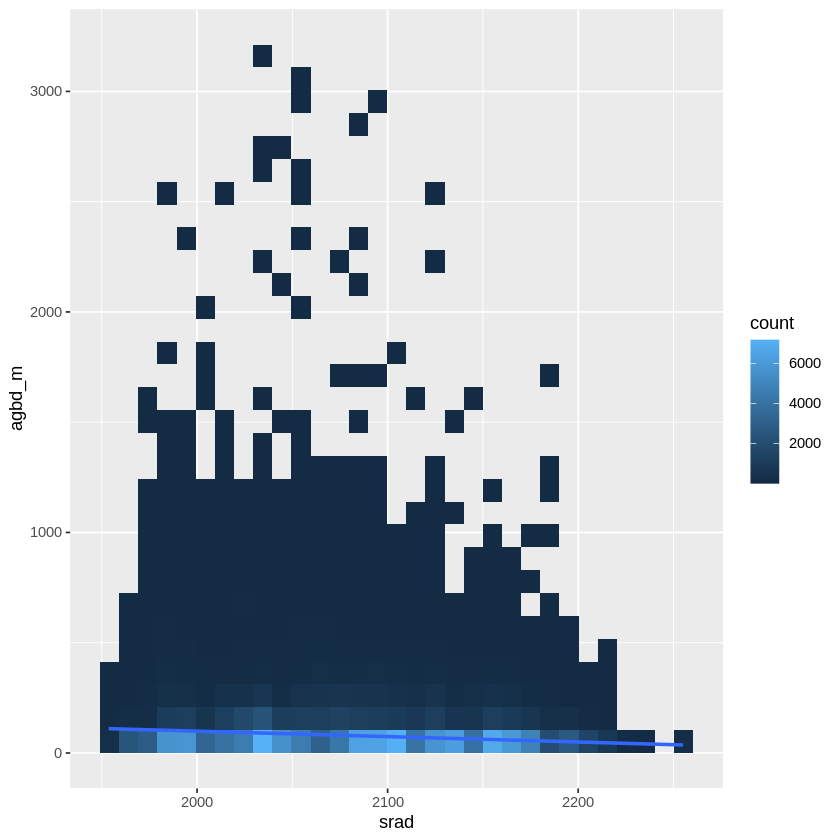

In [117]:
rf_dt %>%
  ggplot(aes(x=srad,y=agbd_m)) +
  # xlim(0,500)+

  geom_bin2d() +
    geom_smooth(method='lm')

In [73]:
# https://drive.google.com/drive/folders/1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM?usp=drive_link
drive_upload("/content/250_summary_grid_dt.gpkg", path = as_id("1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM"))

Auto-refreshing stale OAuth token.

Local file:

• /content/250_summary_grid_dt.gpkg

Uploaded into Drive file:

• 250_summary_grid_dt.gpkg <id: 1g-iZB4xPa-7gYKu45y06Qc4hbYW7Lwqm>

With MIME type:

• application/geopackage+sqlite3

